# read data + dummies + nan to mean

- единственную категориальную фичу решил закодировать как dummie фичу, нежели присвоить значения 1, 2 и 3, чтобы они не вносили вклад в модель 
- семплы с пропущнными значениями решил не удалять, а заменить на средние по фиче, чтобы не терять данные, в особенности семплы со значением таргета 1

In [133]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [106]:
train_df = pd.read_csv('data/PD-data-train.csv', sep=';')
test_df = pd.read_csv('data/PD-data-test.csv', sep=';')
desc_df = pd.read_csv('data/PD-data-desc.csv', sep=';')

In [107]:
train_df = pd.concat([train_df.drop(columns=['ul_staff_range']), pd.get_dummies(data=train_df['ul_staff_range'])], axis=1)
test_df = pd.concat([test_df.drop(columns=['ul_staff_range']), pd.get_dummies(data=test_df['ul_staff_range'])], axis=1)

In [108]:
train_cols = train_df.columns
test_cols = test_df.columns

In [109]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
train_df = pd.DataFrame(imp_mean.fit_transform(train_df), columns=train_cols)
test_df = pd.DataFrame(imp_mean.fit_transform(test_df), columns=test_cols)

In [110]:
train_df[train_df['default_12m'] == 0].shape[0], train_df[train_df['default_12m'] == 1].shape[0]

(30304, 2091)

# solve class-disnalance problem ('cause acc_score on test)

## oversampling

самый обычный оверсемплинг, копирование одних и тех же семплов, пока не будет достигнут примерный баланс классов

In [8]:
zeros = train_df[train_df['default_12m'] == 0].copy()
zeros.shape

(30304, 39)

In [9]:
ones = train_df[train_df['default_12m'] == 1].copy()
ones.shape

(2091, 39)

In [10]:
cache = ones.copy()
for _ in range(14):
    ones = pd.concat([ones, cache], axis=0, ignore_index=True)

In [11]:
ones = ones.reset_index(drop=True)

In [12]:
overs_train = pd.concat([zeros, ones], axis=0).sample(frac=1).reset_index(drop=True)

In [13]:
overs_train.shape

(61669, 39)

## Undersampling

в качестве обычного андерсемплинга решил не рандомно выбрать семплы из превалирующего класса, а рассмотреть все подвыборки, чтобы не потерять важных семплов

In [14]:
ones_unders = train_df[train_df['default_12m'] == 1].copy()
ones_unders.shape

(2091, 39)

In [15]:
list_zeros = list()
zeros = train_df[train_df['default_12m'] == 0].copy()

s = 0
while s != 30000:
    list_zeros.append(zeros.iloc[s:s+2000, :])
    s += 2000

In [16]:
len(list_zeros), list_zeros[0].shape

(15, (2000, 39))

## Nearmiss v1

из большего класса выбираем объекты, у которых среднее расстояний до N ближайших малого класса наименьшее

In [17]:
nm = NearMiss()

In [18]:
X_nm, y_nm = nm.fit_resample(train_df.drop(columns=['default_12m']), train_df['default_12m'])

In [19]:
sum(y_nm == 0), sum(y_nm == 1)

(2091, 2091)

## ADASYN (SMOTE like algorithm)

почему-то со smote тут были проблемы, и он наоборот делал андерсемплинг, выбрал adasyn, ибо это примерно то же самое: берем пары объектов меньшего класса, между ними генерируем новые в количестве пропорциональном объектам большего класса поблизости

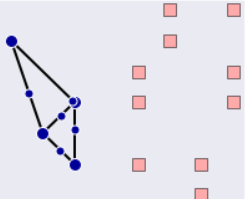

In [20]:
sum(train_df['default_12m'] == 0), sum(train_df['default_12m'] == 1)

(30304, 2091)

In [21]:
ada = ADASYN(random_state=42)
X_ada, y_ada = ada.fit_resample(train_df.drop(columns=['default_12m']), train_df['default_12m'])

In [22]:
sum(y_ada == 0), sum(y_ada == 1)

(30304, 30246)

# train models

здесь просто берем базовые модели мл, тестируем их на всех вариантах данных, и сабмитим лучшие 

## knn, best test score 0.555

In [23]:
# oversampling
data = overs_train
x, y = data.drop(columns=['default_12m']), data['default_12m']
res = np.mean(cross_val_score(KNeighborsClassifier(), x, y, scoring='accuracy'))
print(f'oversampling knn: {round(res, 4)}')

# undersampling
res = 0
idz = -1
for i in range(15):
    data = pd.concat([ones_unders, list_zeros[i]], axis=0).sample(frac=1).reset_index(drop=True)
    x, y = data.drop(columns=['default_12m']), data['default_12m']
    acc = np.mean(cross_val_score(KNeighborsClassifier(), x, y, scoring='accuracy'))
    if acc > res:
        res = acc
        idx = i
print(f'undersampling {i} knn: {round(res, 4)}')

# nearmiss v1
res = np.mean(cross_val_score(KNeighborsClassifier(), X_nm, y_nm, scoring='accuracy'))
print(f'nearmiss knn: {round(res, 4)}')

# adasyn
res = np.mean(cross_val_score(KNeighborsClassifier(), X_ada, y_ada, scoring='accuracy'))
print(f'adasyn knn: {round(res, 4)}')

oversampling knn: 0.9029
undersampling 14 knn: 0.7974
nearmiss knn: 0.6686
adasyn knn: 0.6608


In [24]:
model = KNeighborsClassifier()
params = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
gcv = GridSearchCV(model, param_grid=params, scoring='accuracy', n_jobs=-1)
data = overs_train
x, y = data.drop(columns=['default_12m']), data['default_12m']
gcv.fit(x, y)
model = gcv.best_estimator_
print(round(gcv.best_score_, 4) * 100, '%')

96.39 %


In [25]:
preds = model.predict(test_df)
ans = pd.concat([test_df['record_id'], pd.DataFrame(preds)], axis=1)

In [26]:
ans.columns = ['id', 'predict']
ans = ans.astype(int)

In [27]:
ans.to_csv('knn_oversampling.csv', index=False, sep=';')

## Decision tree, best test score 0.54

In [127]:
clf = DecisionTreeClassifier(random_state=0)
np.mean(cross_val_score(clf, train_df.drop(columns=['default_12m']), train_df['default_12m'], cv=5, scoring='accuracy'))

0.707856150640531

In [128]:
# oversampling
data = overs_train
x, y = data.drop(columns=['default_12m']), data['default_12m']
res = np.mean(cross_val_score(DecisionTreeClassifier(), x, y, scoring='accuracy'))
print(f'oversampling tree: {round(res, 4)}')

# undersampling
res = 0
idz = -1
for i in range(15):
    data = pd.concat([ones_unders, list_zeros[i]], axis=0).sample(frac=1).reset_index(drop=True)
    x, y = data.drop(columns=['default_12m']), data['default_12m']
    acc = np.mean(cross_val_score(DecisionTreeClassifier(), x, y, scoring='accuracy'))
    if acc > res:
        res = acc
        idx = i
print(f'undersampling {i} tree: {round(res, 4)}')

# nearmiss v1
res = np.mean(cross_val_score(DecisionTreeClassifier(), X_nm, y_nm, scoring='accuracy'))
print(f'nearmiss tree: {round(res, 4)}')

# adasyn
res = np.mean(cross_val_score(DecisionTreeClassifier(), X_ada, y_ada, scoring='accuracy'))
print(f'adasyn tree: {round(res, 4)}')

oversampling tree: 0.9641
undersampling 14 tree: 0.9423
nearmiss tree: 0.644
adasyn tree: 0.6557


In [130]:
model = DecisionTreeClassifier()
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11))
}
gcv = GridSearchCV(model, param_grid=params, scoring='accuracy', n_jobs=-1)
data = overs_train
x, y = data.drop(columns=['default_12m']), data['default_12m']
gcv.fit(x, y)
model = gcv.best_estimator_
print(round(gcv.best_score_, 4) * 100, '%')

96.49 %


In [132]:
preds = model.predict(test_df)
ans = pd.concat([test_df['record_id'], pd.DataFrame(preds)], axis=1)
ans.columns = ['id', 'predict']
ans = ans.astype(int)
ans.to_csv('tree_oversampling.csv', index=False, sep=';')

## Random forest, 0.525 test score

In [ ]:
# simple data random forest 

In [137]:
clf = RandomForestClassifier()
params = {
    'n_estimators': [50, 100, 150, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'class_weight': ['balanced', 'balanced_subsample', None]
}
x, y = train_df.drop(columns=['default_12m']), train_df['default_12m']
gcv = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=-1)
gcv.fit(x, y)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample',
                                          None],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy')

In [138]:
model = gcv.best_estimator_
print(round(gcv.best_score_, 4) * 100, '%')

93.08 %


In [140]:
preds = model.predict(test_df)
ans = pd.concat([test_df['record_id'], pd.DataFrame(preds)], axis=1)
ans.columns = ['id', 'predict']
ans = ans.astype(int)
ans.to_csv('forest_simple.csv', index=False, sep=';')

## Logres clf, best test score 0.495

In [28]:
data = train_df.drop(columns=['default_12m'])
target = train_df['default_12m']
cols = data.columns

test = test_df

помимо нормализации данных решил проверить фичи на корреляцию, и удалить коррелирующие 

In [29]:
# delete multicorr features
def drop_corr(data):
    # Create correlation matrix
    corr_matrix = data.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find features with correlation greater than 0.9
    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

    # Drop features 
    data.drop(to_drop, axis=1, inplace=True)
    return data, to_drop

In [30]:
%%capture --no-stdout

# balance weights
data = train_df
x, y = data.drop(columns=['default_12m']), data['default_12m']
x, _ = drop_corr(x)
scr = StandardScaler()
x = scr.fit_transform(x)
auc = np.mean(cross_val_score(LogisticRegression(class_weight='balanced'), x, y, scoring='roc_auc'))
print(f'balance logres: {round(res, 4)}')

# oversampling
data = overs_train
x, y = data.drop(columns=['default_12m']), data['default_12m']
x, _ = drop_corr(x)
scr = StandardScaler()
x = scr.fit_transform(x)
auc = np.mean(cross_val_score(LogisticRegression(), x, y, scoring='roc_auc'))
print(f'oversampling logres: {round(res, 4)}')

# undersampling
res = 0
idz = -1
for i in range(15):
    data = pd.concat([ones_unders, list_zeros[i]], axis=0).sample(frac=1).reset_index(drop=True)
    x, y = data.drop(columns=['default_12m']), data['default_12m']
    x, _ = drop_corr(x)
    scr = StandardScaler()
    x = scr.fit_transform(x)
    auc = np.mean(cross_val_score(LogisticRegression(), x, y, scoring='roc_auc'))
    if auc > res:
        res = auc
        idx = i
print(f'undersampling {i} logres: {round(res, 4)}')

# nearmiss v1
X_nm, _ = drop_corr(X_nm)
scr = StandardScaler()
X_nm = scr.fit_transform(X_nm)
res = np.mean(cross_val_score(LogisticRegression(), X_nm, y_nm, scoring='roc_auc'))
print(f'nearmiss logress: {round(res, 4)}')

# adasyn
X_ada, _ = drop_corr(X_ada)
scr = StandardScaler()
X_ada = scr.fit_transform(X_ada)
res = np.mean(cross_val_score(LogisticRegression(), X_ada, y_ada, scoring='roc_auc'))
print(f'adasyn logress: {round(res, 4)}')

balance logres: 0.6608
oversampling logres: 0.6608
undersampling 14 logres: 0.9673
nearmiss logress: 0.6699
adasyn logress: 0.6549


In [50]:
# %%capture --no-stdout

model = LogisticRegression(max_iter=5000)
params = {
    'penalty': ['l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'tol': [1e-3, 1e-4, 1e-5],
    'C': [0.5, 1.0, 1.5]
}
gcv = GridSearchCV(model, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=10)
data = pd.concat([ones_unders, list_zeros[14]], axis=0).sample(frac=1).reset_index(drop=True)
x, y = data.drop(columns=['default_12m']), data['default_12m']
x, _ = drop_corr(x)
scr = StandardScaler()
x = scr.fit_transform(x)
gcv.fit(x, y)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


/tmp/ipykernel_24997/3847225627.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


[CV 3/5; 1/45] START C=0.5, penalty=l2, solver=newton-cg, tol=0.001.............
[CV 3/5; 1/45] END C=0.5, penalty=l2, solver=newton-cg, tol=0.001;, score=0.961 total time=   0.1s
[CV 1/5; 3/45] START C=0.5, penalty=l2, solver=newton-cg, tol=1e-05.............
[CV 1/5; 3/45] END C=0.5, penalty=l2, solver=newton-cg, tol=1e-05;, score=0.946 total time=   0.2s
[CV 4/5; 4/45] START C=0.5, penalty=l2, solver=lbfgs, tol=0.001.................
[CV 4/5; 4/45] END C=0.5, penalty=l2, solver=lbfgs, tol=0.001;, score=0.976 total time=   0.1s
[CV 5/5; 5/45] START C=0.5, penalty=l2, solver=lbfgs, tol=0.0001................
[CV 5/5; 5/45] END C=0.5, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.966 total time=   0.1s
[CV 5/5; 7/45] START C=0.5, penalty=l2, solver=liblinear, tol=0.001.............
[CV 5/5; 7/45] END C=0.5, penalty=l2, solver=liblinear, tol=0.001;, score=0.965 total time=   0.1s
[CV 2/5; 9/45] START C=0.5, penalty=l2, solver=liblinear, tol=1e-05.............
[CV 2/5; 9/45] END C=0.5, 

GridSearchCV(estimator=LogisticRegression(max_iter=5000), n_jobs=-1,
             param_grid={'C': [0.5, 1.0, 1.5], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'],
                         'tol': [0.001, 0.0001, 1e-05]},
             scoring='roc_auc', verbose=10)

In [51]:
model = gcv.best_estimator_
print(round(gcv.best_score_, 4) * 100, '%')

96.36 %


In [112]:
scr = StandardScaler()
test = scr.fit_transform(test_df.drop(_, axis=1))

In [115]:
preds = model.predict(test)
ans = pd.concat([test_df['record_id'], pd.DataFrame(preds)], axis=1)
ans.columns = ['id', 'predict']
ans = ans.astype(int)
ans.to_csv('logress_undersampling.csv', index=False, sep=';')

# Выводы

Как показывает скор на закрытом датасете, линейная модель показала себя хуже, полагаю, взаимное расположение объектов классов сложо разделить прямой. Полагаю, проблема в разреженности классов (вроде как не то же самое, что и дисбаланс), когда один класс по природе своей встречается много реже другого.